# Clustering Countries' Based on Their Pandemic Performance with K-medoids

## Introduction

K-medoids is similar to the commonly-used K-means, but rather than finding centroids to represent clusters, it finds medoids, which represent real data points in the dataset (Arora et al., 2016). K-medoids is thus more robust in the presence of outliers (Arora et al., 2016).

In this analysis, I attempted to cluster (most of the) countries of the world into interpretable clusters based on four COVID-19-related indicators:
- total cases per million people
- total deaths per million people
- total vaccinations per hundred people
- GDP growth (as a percentage) in 2020 (over 2019).

The first three indicators came from [Our World in Data's COVID-19 dataset](https://github.com/owid/covid-19-data/tree/master/public/data), which they in turn collected from [JHU CSSE COVID-19 Data](https://github.com/CSSEGISandData/COVID-19). That data was retrieved on July 13th, 2021, and is accurate up to that date. The estimates of GDP growth (as a percentage) are courtesy of the [World Bank](https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG). 
    
It had to be kept in mind (while examining the results) that the first two indicators were likely to be undercounted for most countries, as they represented only confirmed cases and deaths. This was especially a concern for nations in the developing world with lesser testing capacities. Some countries may also have intentionally undercounted cases and deaths and/or overcounted their amount of vaccinations.

## Data Preparation

I started by loading in the two datasets and ensuring they were joined correctly.

In [1]:
# import the necessary modules
import pandas as pd
pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 201)
import sklearn.preprocessing as pre
import sklearn_extra.cluster as clus
import sklearn.decomposition as decomp
import seaborn as sns
import matplotlib.pyplot as plot

# load in the datasets
dataset_covid = pd.read_csv("owid-covid-latest.txt")
world_bank_gdp_data = pd.read_csv("API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_2593046.csv", index_col = "Country Code")

# isolate the columns of interest from the first (i.e. primary) dataset
dataset = dataset_covid.loc[:, ["location", "iso_code", "continent", "total_cases_per_million","total_deaths_per_million","total_vaccinations_per_hundred"]]
# set the country name to be the index for that dataframe
dataset.set_index(keys = "iso_code", drop = "iso_code", inplace = True)

# join the GDP dataset to our primary dataset
dataset = pd.merge(dataset, world_bank_gdp_data["2020"], left_index = True, right_index = True, how = "left")
# rename the GDP column
dataset.rename(columns = {"2020":"gdp_growth_%_2020"}, inplace = True)

# this will drop aggregate rows (i.e., rows representing the E.U., the world, etc.)
dataset.drop([i for i in dataset.index.values if "OWID" in i], axis = 0, inplace = True)

# examine the first several rows
display(dataset.head(n=10))

,location,continent,total_cases_per_million,total_deaths_per_million,total_vaccinations_per_hundred,gdp_growth_%_2020
iso_code,,,,,,
AFG,Afghanistan,Asia,3274.324,137.689,2.35,-1.934778
ALB,Albania,Europe,46057.405,853.430,34.75,-3.311239
DZA,Algeria,Africa,3248.429,86.087,NaN,-5.480992
AND,Andorra,Europe,181078.108,1643.694,88.43,-11.956058
AGO,Angola,Africa,1198.037,27.992,4.60,-4.040510
AIA,Anguilla,North America,NaN,NaN,109.72,NaN
ATG,Antigua and Barbuda,North America,12917.654,428.887,66.06,-15.973510
ARG,Argentina,South America,101211.669,2145.842,50.48,-9.905235
ARM,Armenia,Asia,76153.621,1528.735,2.52,-7.600000


It was immediately clear that some of the indicators had missing values for some nations. Imputation, I believed, was preferable to throwing out any countries missing a value. I hypothesized that a country's geographic location may be a predictor of these missing values, and generated boxplots to investigate the possibility.

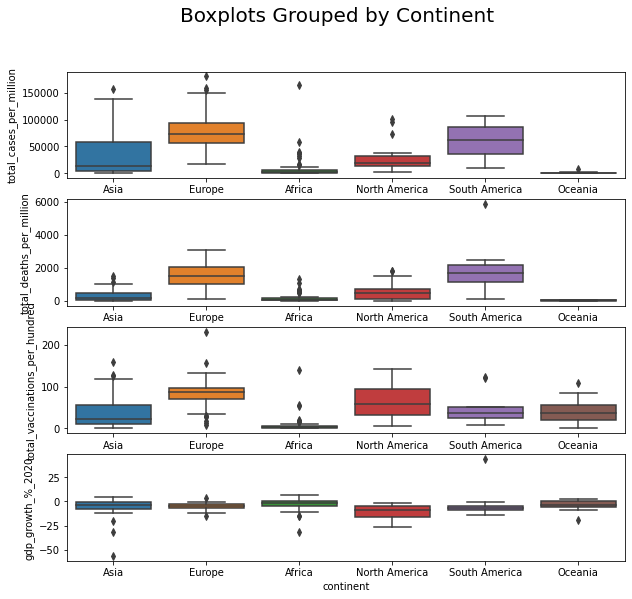

In [2]:
#create a figure to store 4 boxplots with continent as the grouping variable
fig, axs = plot.subplots(nrows=len(dataset.columns.values[2:]), ncols=1, figsize = (10,9))

#add title
fig.suptitle("Boxplots Grouped by Continent", fontsize = 20)

#add data to plots
for i in range(len(dataset.columns.values[2:])):
    sns.boxplot(ax=axs[i], data=dataset, x="continent", y=dataset.columns.values[2+i])
plot.show()

The boxplots suggested that the distribution of these indicators seemed to generally differ by continent, and many of these distributions were skewed or had outliers. Thus, it was prudent to fill missing values with the median of that statistic on the country's continent.

In [3]:
# fill in missing values with the median value from their given continent
for i in dataset.columns.values[2:]:
    dataset[i] = dataset[i].fillna(dataset.groupby("continent")[i].transform('median'))
# rexamine the first several rows
display(dataset.head(n=10))

,location,continent,total_cases_per_million,total_deaths_per_million,total_vaccinations_per_hundred,gdp_growth_%_2020
iso_code,,,,,,
AFG,Afghanistan,Asia,3274.324,137.6890,2.35,-1.934778
ALB,Albania,Europe,46057.405,853.4300,34.75,-3.311239
DZA,Algeria,Africa,3248.429,86.0870,2.83,-5.480992
AND,Andorra,Europe,181078.108,1643.6940,88.43,-11.956058
AGO,Angola,Africa,1198.037,27.9920,4.60,-4.040510
AIA,Anguilla,North America,19776.682,445.8885,109.72,-8.964760
ATG,Antigua and Barbuda,North America,12917.654,428.8870,66.06,-15.973510
ARG,Argentina,South America,101211.669,2145.8420,50.48,-9.905235
ARM,Armenia,Asia,76153.621,1528.7350,2.52,-7.600000


I then scaled the data (which was especially important because of the orders of magnitude varying greatly between the different indicators).

In [4]:
# scale the data
scaled_data = pre.RobustScaler().fit_transform(dataset.loc[:, "total_cases_per_million":])

## K-medoids Analysis

An appropriate value for K (the number of clusters) had to be decided on. To do this, I plotted the distortion metric from several k-medoid solutions, each varying in K. The optimal value for K exists at the elbow of the curve.

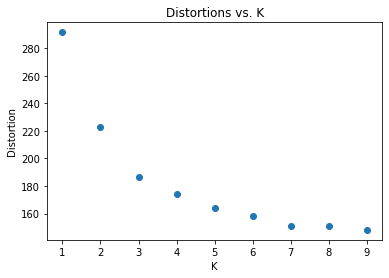

In [5]:
# grab the distortions after each k-means run with a different k 
distortions = list()
for k in range(1,10):
    k_medoid_elbow_model = clus.KMedoids(n_clusters = k).fit(scaled_data)
    distortions.append(k_medoid_elbow_model.inertia_)
    
# plot these distortions vs k
plot.scatter(range(1,10), distortions)
plot.xlabel("K")
plot.ylabel("Distortion")
plot.title("Distortions vs. K")
plot.show()

This method of choosing K is somewhat subjective, but the plot suggested that five clusters was appropriate. I ran the algorithm using K = 5, and found the medoids for these five clusters (which I remind the reader, represent actual observations or countries). In the appendix at the end of this report, I provided a list of all the countries involved in the analysis, and all of the clusters they were mapped to.

In [6]:
# conduct the k-means analysis
k_medoids = clus.KMedoids(n_clusters=5).fit(scaled_data)
display(pd.DataFrame(k_medoids.cluster_centers_, columns = dataset.loc[:, "total_cases_per_million":].columns))

,total_cases_per_million,total_deaths_per_million,total_vaccinations_per_hundred,gdp_growth_%_2020
0,-0.044256,0.040985,-0.321982,-0.939667
1,0.171346,0.027455,0.535243,-0.396792
2,0.965760,1.199614,0.688440,-0.055406
3,-0.263184,-0.301208,-0.294865,0.908699
4,-0.262776,-0.286066,-0.365952,0.128143


In [7]:
# grab data for representative of first cluster
display(dataset.loc[scaled_data[:,0] == k_medoids.cluster_centers_[0,0],:])

,location,continent,total_cases_per_million,total_deaths_per_million,total_vaccinations_per_hundred,gdp_growth_%_2020
iso_code,,,,,,
JAM,Jamaica,North America,17021.702,370.125,8.44,-10.2


Jamaica serves as the representative for the first cluster. Like other countries in this cluster, Jamaica managed to protect the health of its citizens reasonably well, but their economy fared particularly poorly in 2020.

In [8]:
# grab data for representative of second cluster
display(dataset.loc[scaled_data[:,0] == k_medoids.cluster_centers_[1,0],:])

,location,continent,total_cases_per_million,total_deaths_per_million,total_vaccinations_per_hundred,gdp_growth_%_2020
iso_code,,,,,,
DOM,Dominican Republic,North America,30443.116,356.382,76.09,-6.720239


The second cluster is best represented by the Dominican Republic. Healthcare systems and the economies in this cluster tended to have been hit hard by COVID-19 (but not the hardest). Thankfully, such countries were able to get vaccines into arms relatively quickly. 

In [9]:
# grab data for representative of third cluster
display(dataset.loc[scaled_data[:,0] == k_medoids.cluster_centers_[2,0],:])

,location,continent,total_cases_per_million,total_deaths_per_million,total_vaccinations_per_hundred,gdp_growth_%_2020
iso_code,,,,,,
LIE,Liechtenstein,Europe,79896.164,1547.054,88.18,-4.531995


Liechenstein is an example of a member of the third cluster. COVID-19 has hit the healthcare systems of these countries by far the hardest. Case numbers and deaths were both high for these countries. However, they have been the most successful at vaccinating their populations.

In [10]:
# grab data for representative of fourth cluster
display(dataset.loc[scaled_data[:,0] == k_medoids.cluster_centers_[3,0],:])

,location,continent,total_cases_per_million,total_deaths_per_million,total_vaccinations_per_hundred,gdp_growth_%_2020
iso_code,,,,,,
UZB,Uzbekistan,Asia,3393.209,22.528,10.58,1.647797


Cluster four is represented by Uzbekistan. Despite limited success in vaccinating their populations, such countries fared the best economically (with some even seeing growth in 2020). They have also fared the best in terms of health outcomes.

In [11]:
# grab data for representative of fifth cluster
display(dataset.loc[scaled_data[:,0] == k_medoids.cluster_centers_[4,0],:])

,location,continent,total_cases_per_million,total_deaths_per_million,total_vaccinations_per_hundred,gdp_growth_%_2020
iso_code,,,,,,
RWA,Rwanda,Africa,3418.645,37.909,4.97,-3.355472


This leaves the last cluster to be represented by Rwanda. The main difference between this cluster and the last is that the members of this cluster had taken more of an economic hit.

Below, I generated boxplots for our four indicators (grouped by cluster) so one can better visualize how these groups differ quantitatively.

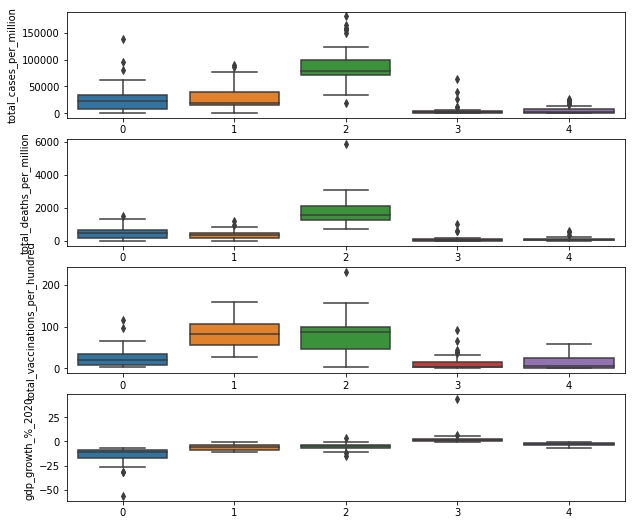

In [12]:
# create a figure to store 4 boxplots with cluster as the grouping variable
fig, axs = plot.subplots(nrows=len(dataset.columns.values[2:]), ncols=1, figsize = (10,9))

# add data to plots
for i in range(len(dataset.columns.values[2:])):
    sns.boxplot(ax=axs[i], data=dataset, x=k_medoids.labels_, y=dataset.columns.values[2+i])
plot.show()

I then plotted where the clusters are located geographically, so one can better visualize how they are distributed around the world. Perhaps unsurprisingly, the third cluster dominates the Americas and Europe.

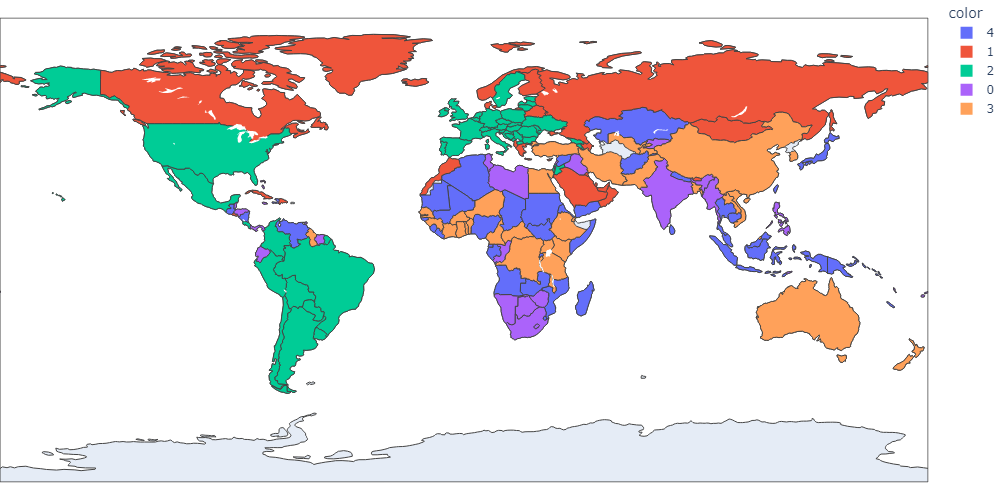

In [13]:
import plotly.express as px

# plot the clusters on the countries of the world
fig = px.choropleth(dataset, locations=dataset.index.values,
                    color=list(map(str, k_medoids.labels_)),
                    color_continuous_scale=px.colors.sequential.Plasma, width = 1000, height = 500)
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.show(renderer = "png")

## References

Arora, P., Deepali, & Varshney, S. (2016). Analysis of K-Means and K-Medoids Algorithm For Big Data. _Procedia       Computer Science, 78_, 507-512. doi:10.1016/j.procs.2016.02.095

Dong E, Du H, Gardner L. An interactive web-based dashboard to track COVID-19 in real time. _Lancet Inf Dis. 20(5)_:533-534. doi: 10.1016/S1473-3099(20)30120-1

World Bank, World Development Indicators. (2021). _GDP growth (annual %)_ [data file]. Retrieved from https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG

## Appendix

Below is a table outlining what cluster each country in the dataset was mapped to.

In [14]:
print(pd.Series(k_medoids.labels_, name = "cluster", index = dataset["location"]).to_markdown(tablefmt = "grid"))

+----------------------------------+-----------+
| location                         |   cluster |
+==================================+===========+
| Afghanistan                      |         4 |
+----------------------------------+-----------+
| Albania                          |         1 |
+----------------------------------+-----------+
| Algeria                          |         4 |
+----------------------------------+-----------+
| Andorra                          |         2 |
+----------------------------------+-----------+
| Angola                           |         4 |
+----------------------------------+-----------+
| Anguilla                         |         1 |
+----------------------------------+-----------+
| Antigua and Barbuda              |         0 |
+----------------------------------+-----------+
| Argentina                        |         2 |
+----------------------------------+-----------+
| Armenia                          |         2 |
+-------------------